In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 41.8 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

# Sz=0, the three lowest state using exact diagonalization for HLi

After creating the LiH's Hamitonian in terms of Pauli operators. We directly diagonalize the Hamiltonian and filter out the states which don't conserve the charge.

In [ ]:
def vec_check(vec,electron_num):
    """
    To check whether solution conserves the charge
    Arg:
       vec: the state vector (numpy array).
       electron_num: the number of electrons
    """
    for i,e in enumerate(vec):
        if np.abs(e) > 1e-8:
            e_occ=bin(i)[2:]
            lst=' '.join(e_occ).split(' ')
            cv=tuple(map(int, lst))
            e_num=sum(cv)
            if e_num!=electron_num:
                return False
    return True

def exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge):
    """
      num_electrons: The number of electrons

      symbol: The chemistry symbol (i.e. ["H","H"] for H2)

      geometry: The coodinates of the atoms in bohr

      charge: the charge of the chemical molecules

      return: the three lowest states with Sz=0
    """

    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]
    H_matrix=qml.matrix(Ha)
    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    vals, vecs = np.linalg.eigh(H_matrix+0.00001*SZ)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]
    E_collect=[eng[0]]
    print('The ground state energy with sz=0:',eng[0])

    elec_num=num_electrons
    k=0
    for i in range(1,len(eng)): # Finding first excited state with -1 Sz
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if  np.abs(Sz.real)<1e-5 and vec_check(vec[:,i],elec_num):
            print('The energy state:',(eng[i]-0.00001*Sz).real,' with Sz=',round(Sz.real,3))

            E_collect.append((eng[i]-0.00001*Sz).real)
            k+=1
        if k==2:
            break

    return E_collect


In [ ]:
r_lst=[0.5,1.0,1.5,2.0,2.5,3.0,3.5] # Radius list
E_dict={}

E_0__lst=[]
E_1__lst=[]
E_2__lst=[]

for r in r_lst:
    a0=0.529177210903
    L=r/a0                    # Convert unit from Bohr to atomic unit
    symbol=["H", "Li"]        # HLi
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2
    E0,E1,E2=exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge)

    E_0__lst.append(E0)
    E_1__lst.append(E1)
    E_2__lst.append(E2)



The ground state energy with sz=0: -7.047909872435877
The energy state: -7.004725350507367  with Sz= -0.0
The energy state: -6.986551586303331  with Sz= -0.0
The ground state energy with sz=0: -7.7840213247501415
The energy state: -7.658342766396839  with Sz= -0.0
The energy state: -7.643809651162712  with Sz= -0.0
The ground state energy with sz=0: -7.882139972573577
The energy state: -7.759969497124905  with Sz= -0.0
The energy state: -7.743624936624278  with Sz= -0.0
The ground state energy with sz=0: -7.8608282818410204
The energy state: -7.775551605885384  with Sz= -0.0
The energy state: -7.752282360954605  with Sz= -0.0
The ground state energy with sz=0: -7.823426970817585
The energy state: -7.777598560023308  with Sz= -0.0
The energy state: -7.741012762416143  with Sz= -0.0
The ground state energy with sz=0: -7.798504254068346
The energy state: -7.77941993852736  with Sz= 0.0
The energy state: -7.724083106746683  with Sz= -0.0
The ground state energy with sz=0: -7.79096426629949

# Variational Quantum Deflation

VQD is the VQE to evaluate the k th excited state's energy with the cost function

$C\left(\vec{\theta}_{k}\right)=\left\langle \psi_{k}(\vec{\theta}_{k})\left|H\right|\psi_{k}(\vec{\theta}_{k})\right\rangle +\sum_{i=0}^{k-1}\beta_i\left|\left\langle \psi_{i}(\vec{\theta}_{i})|\psi_{k}(\vec{\theta}_{k})\right\rangle ^{2}\right|$

Where and $\left|\psi_{i}(\vec{\theta_{i}})\right\rangle$ are the k-1 lowest eigenstates which put the cconstraints that $\left|\psi_{k}(\vec{\theta_{k}})\right\rangle $ is orthognal to thoes eigenstates. $\left|\psi_{k}\right\rangle $, $\left|\psi_{k-1}\right\rangle $.... means different initial trial states.Moreover, $\beta_i$ is should sfficient (larger than the band gap between the ground state and the first excited state.)





As the plot shown below, each qubit can be explained whether the electrons occupy the spin orbitals. $1$ means the occupied orbital, while $0$ means empty orbital. Even (odd) sites mean spin up (down) orbital. (Plot from	Phys. Chem. Chem. Phys., 2021,23, 26438-26450)

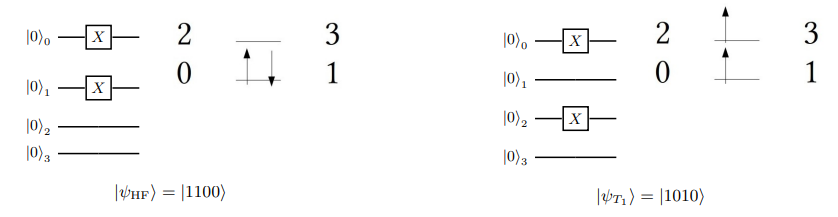

In [ ]:
def bit_to_vec(bitstring_dict,num_qubits): # Convert the bitstring to statevector

    vec=np.zeros(2**num_qubits)
    amp=0
    for i in range(2**num_qubits):
        bitstr=bin(i)[2:]
        if len(bitstr) < num_qubits:
            bitstr=(num_qubits-len(bitstr))*'0'+bitstr

        if bitstr in bitstring_dict:
            vec[i]=bitstring_dict[bitstr]
            amp+=np.abs(bitstring_dict[bitstr])**2
    vec=vec/np.sqrt(amp)
    return vec

In [ ]:
class VQD_ch():
    def __init__(self,state_lst,num_electrons,symbol,geometry,charge):
        """
        state_lst list(dict): The list of trial states for training the VQD

        For instance, you want to create |ψ_1>=1/√2|110000>+1/√2|001100>
        and |ψ_2>=1/√2|110000>-1/√2|001100> as the 6 qubits trial states

        state_psi_1={'110000':1,'001100':1}
        state_psi_2={'110000':1,'001100':-1}
        state_lst=[state_psi_1,state_psi_2]

        The length of bitstring is determined by the number of orbital. H3+ has 6 orbitals so the
        of bit string is 6.

        num_electrons (int): The number of electrons

        symbol list(str): The chemistry symbol (i.e. ["H","H"] for H2)

        geometry numpy array: The coodinates of the atoms in bohr

        charge int: the charge of the chemical molecules
        """

        self.num_electrons=num_electrons
        self.symbol=symbol
        self.geometry=geometry
        self.charge=charge

        self.hamiltonian=self.Ch_hamiltonian(symbol,geometry,num_electrons,charge)
        self.num_qubits = len(self.hamiltonian.wires)
        self.sz=qml.qchem.spinz(self.num_qubits)
        self.singles, self.doubles = qml.qchem.excitations(self.num_electrons, self.num_qubits)
        self.state_lst=[]
        for stat in state_lst:
            self.state_lst.append(bit_to_vec(stat,self.num_qubits))

        self.weight_dict={}
        self.th_state=0
        self.Eng_lst=[]

        self.dev = qml.device("default.qubit", wires=self.num_qubits)
        self.cost_h_fn = qml.QNode(self.circuit, self.dev)
        self.Sz_fn = qml.QNode(self.circuit_sz, self.dev)
        self.cost_fid_fn = qml.QNode(self.circuit_fid, self.dev)
        self.num_ly_lst=[]

    def Ch_hamiltonian(self,symbol,geometry,num_electrons,charge): # Create the Hamiltonian of molecules
        return qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]

    def hf(self,electrons, num_qubits): #Create trial state for the ground state
        return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

    def circuit(self,state,weights): #evalutate the expectation value of the Hamiltonian
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.hamiltonian)

    def circuit_sz(self,state,weights): #evalutate the expectation value of the Sz
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.sz)

    def circuit_fid(self,state,params,weights,ind): #To calculate the fidelity between one of trained states and training state.
        qml.StatePrep(state, wires=range(self.num_qubits))
        Re_w=weights.copy()[::-1]
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(params[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(params[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])

        Re_single=self.singles.copy()[::-1]
        Re_double=self.doubles.copy()[::-1]
        for j in range(self.num_ly_lst[ind]):
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(-Re_w[i+j*(d_l+s_l)], wires=Re_double[i])
            for i in range(len(self.singles)):
                qml.SingleExcitation(-Re_w[i+d_l+j*(d_l+s_l)], wires=Re_single[i])

        return qml.state() #qml.probs(wires=range(num_qubits))

    def cost_fn(self,params):

        cost=self.cost_h_fn(self.stat,params)
        for ind in range(self.th_state):
            coj_stat=np.conjugate(np.transpose(self.state_lst[ind]))
            final_stat=self.cost_fid_fn(self.stat,params,self.weight_dict[ind],ind)
            fid=np.abs(np.dot(coj_stat,final_stat))**2
            cost+=self.beta*fid
        return cost

    def run(self,beta=3.0,epochs=400,stepsize=0.5,num_layer=2,cov=1e-6,print_train=True):
        """
        beta: the coefficient (larger than the bandgap)

        epochs: the iteration of training

        stepsize: the learning rate

        num_layer: the number of layer ansatz

        cov: if the difference between previous cost and current is samller than cov, the training will be stopped

        print_train: Whether you want to print the training process
        """

        if self.th_state==len(self.state_lst):
            print('Run of states')
            return None
        self.beta=beta
        self.stat=self.state_lst[self.th_state]
        self.num_layer=num_layer
        opt = qml.AdamOptimizer(stepsize=stepsize)
        self.weights =np.zeros(num_layer*len(self.singles+self.doubles), requires_grad=True)

        i=0
        iter=[]
        cost_val=[]
        Lowest_cost=0

        cov=cov
        E_pev=0

        for _ in range(epochs):
            self.weights = opt.step(self.cost_fn, self.weights)
            iter.append(i)
            cost=self.cost_fn(self.weights)

            E0=self.cost_h_fn(self.stat,self.weights)

            cost_val.append(E0)

            i=i+1
            if print_train:
                print('iter:',i)
                print(' E0:',E0,' Sz:',self.Sz_fn(self.stat,self.weights))
                print(cost)
            if np.abs(E0-E_pev)<cov:
                break

            E_pev=E0
        self.Eng_lst=E0
        self.weight_dict[self.th_state]=self.weights
        self.th_state+=1
        self.num_ly_lst.append(num_layer)
        return self.cost_h_fn(self.stat,self.weights)

# For Sz=0, finding the three lowest energy using VQD

In [ ]:
r_lst=[0.5,1.0,1.5,2.0,2.5,3.0,3.5]
E_dict={}

E0_lst=[]
E1_lst=[]
E2_lst=[]

for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "Li"]
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2

    #We guess how ground state looks like
    g_stat={'1100000000': 1}

    ## We guess how the excited state with Sz=0 looks like
    e_stat_0={'0110000000': 1}
    e_stat_1={'1001000000': 1}

    stat_lst=[g_stat,e_stat_0,e_stat_1]
    VQD=VQD_ch(stat_lst,num_electrons,symbol,geometry,charge)
    print('Running '+str(r))

    E0=VQD.run(epochs=400,num_layer=1)
    E1=VQD.run(epochs=400,num_layer=2)
    E2=VQD.run(epochs=400,num_layer=3)

    E0_lst.append(E0)
    E1_lst.append(E1)
    E2_lst.append(E2)


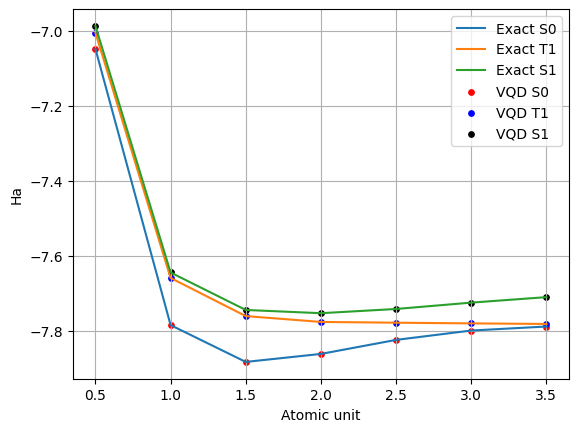

In [ ]:
plt.plot(r_lst,E_0__lst,label='Exact S0')
plt.plot(r_lst,E_1__lst,label='Exact T1')
plt.plot(r_lst,E_2__lst,label='Exact S1')

plt.scatter(r_lst,E0_lst,s=15,c='r',label='VQD S0')
plt.scatter(r_lst,E1_lst,s=15,c='b',label='VQD T1')
plt.scatter(r_lst,E2_lst,s=15,c='k',label='VQD S1')

plt.xlabel('Atomic unit')
plt.ylabel('Ha')

plt.grid()
plt.legend()

In [ ]:
Rel0=np.abs(np.array(E_0__lst)-np.array(E0_lst))/np.abs(np.array(E_0__lst))
Rel1=np.abs(np.array(E_1__lst)-np.array(E1_lst))/np.abs(np.array(E_1__lst))
Rel2=np.abs(np.array(E_2__lst)-np.array(E2_lst))/np.abs(np.array(E_2__lst))

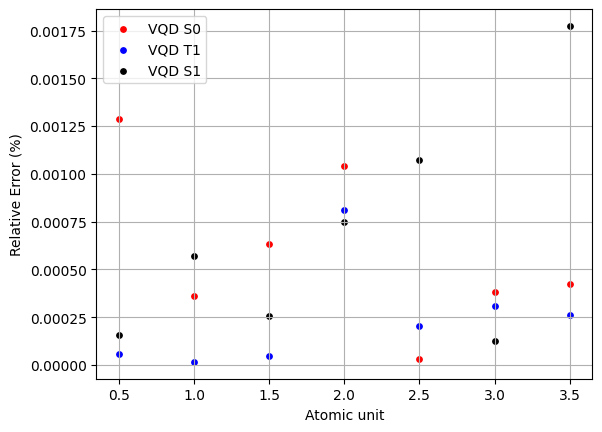

In [ ]:

plt.scatter(r_lst,Rel0*100,s=15,c='r',label='VQD S0')
plt.scatter(r_lst,Rel1*100,s=15,c='b',label='VQD T1')
plt.scatter(r_lst,Rel2*100,s=15,c='k',label='VQD S1')

plt.xlabel('Atomic unit')
plt.ylabel('Relative Error (%)')

plt.grid()
plt.legend()

# For Sz=1, finding the two lowest energy using VQD

In [ ]:
def exact_ch_energy_sz_1(num_electrons,symbol,geometry,charge):

    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]
    H_matrix=qml.matrix(Ha)
    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    vals, vecs = np.linalg.eigh(H_matrix+0.01*SZ)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]
    #E_collect=[0,0,0]
    E_collect=[eng[0]]
    print('The ground state energy with sz=0:',eng[0])

    #Stop=[False,False,False]

    elec_num=num_electrons
    k=0
    for i in range(1,len(eng)): # Finding first excited state with -1 Sz
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if  np.abs(Sz.real-1)<1e-5 and vec_check(vec[:,i],elec_num):
            print('The energy state:',(eng[i]-0.01*Sz).real,' with Sz=',round(Sz.real,3))

            E_collect.append((eng[i]-0.01*Sz).real)
            k+=1
        if k==2:
            break

    return E_collect

In [ ]:
r_lst=[0.5,1.0,1.5,2.0,2.5,3.0,3.5]
E_dict={}

E_0__lst=[]
E_1__lst=[]
E_2__lst=[]

for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "Li"]
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2
    print(r)
    E0,E1,E2=exact_ch_energy_sz_1(num_electrons,symbol,geometry,charge)
    E_0__lst.append(E0)
    E_1__lst.append(E1)
    E_2__lst.append(E2)

0.5
The ground state energy with sz=0: -7.047909872435877
The energy state: -7.00472535050736  with Sz= 1.0
The energy state: -6.9679100583105935  with Sz= 1.0
1.0
The ground state energy with sz=0: -7.7840213247501415
The energy state: -7.658342766396839  with Sz= 1.0
The energy state: -7.618067684104337  with Sz= 1.0
1.5
The ground state energy with sz=0: -7.882139972573577
The energy state: -7.759969497124903  with Sz= 1.0
The energy state: -7.712332320957347  with Sz= 1.0
2.0
The ground state energy with sz=0: -7.8608282818410204
The energy state: -7.775551605885385  with Sz= 1.0
The energy state: -7.716045218289305  with Sz= 1.0
2.5
The ground state energy with sz=0: -7.823426970817585
The energy state: -7.7775985600233035  with Sz= 1.0
The energy state: -7.707189769957235  with Sz= 1.0
3.0
The ground state energy with sz=0: -7.798504254068346
The energy state: -7.779419938527359  with Sz= 1.0
The energy state: -7.701092978024177  with Sz= 1.0
3.5
The ground state energy with sz=0

In [ ]:

E_dict={}

E0_lst=[]
E1_lst=[]
#E2_lst=[]

for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "Li"]
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2
    g_stat={'1010000000': 1} ## We guess how the first excited state with Sz=1 looks like
    e_stat_0={'1000100000': 1} ## We guess how the second excited state with Sz=1 looks like

    stat_lst=[g_stat,e_stat_0]
    VQD=VQD_ch(stat_lst,num_electrons,symbol,geometry,charge)
    print('Running '+str(r))
    E0=VQD.run(epochs=400,num_layer=2)
    E1=VQD.run(epochs=400,num_layer=3)
    #E2=VQD.run(epochs=400,num_layer=3)

    E0_lst.append(E0)
    E1_lst.append(E1)
    #E2_lst.append(E2)


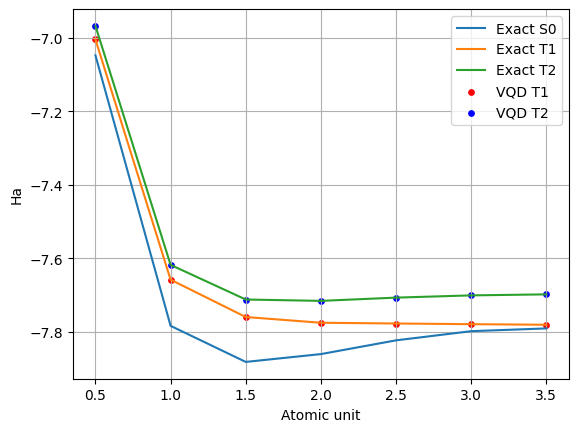

In [ ]:
plt.plot(r_lst,E_0__lst,label='Exact S0')
plt.plot(r_lst,E_1__lst,label='Exact T1')
plt.plot(r_lst,E_2__lst,label='Exact T2')

plt.scatter(r_lst,E0_lst,s=15,c='r',label='VQD T1')
plt.scatter(r_lst,E1_lst,s=15,c='b',label='VQD T2')
plt.xlabel('Atomic unit')
plt.ylabel('Ha')

plt.grid()
plt.legend()

In [ ]:
Rel0=np.abs(np.array(E_1__lst)-np.array(E0_lst))/np.abs(np.array(E_1__lst))
Rel1=np.abs(np.array(E_2__lst)-np.array(E1_lst))/np.abs(np.array(E_2__lst))


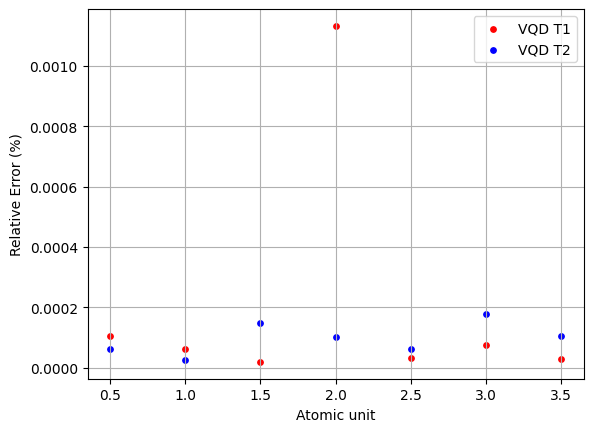

In [ ]:
plt.scatter(r_lst,Rel0*100,s=15,c='r',label='VQD T1')
plt.scatter(r_lst,Rel1*100,s=15,c='b',label='VQD T2')


plt.xlabel('Atomic unit')
plt.ylabel('Relative Error (%)')

plt.grid()
plt.legend()

In [ ]:
class Adapt_VQD_ch():
    def __init__(self,state_lst,num_electrons,symbol,geometry,charge) -> None:
        self.num_electrons=num_electrons
        self.symbol=symbol
        self.geometry=geometry
        self.charge=charge

        self.hamiltonian=self.Ch_hamiltonian(symbol,geometry,num_electrons,charge)
        self.num_qubits = len(self.hamiltonian.wires)
        self.sz=qml.qchem.spinz(self.num_qubits)
        self.singles, self.doubles = qml.qchem.excitations(self.num_electrons, self.num_qubits)
        self.state_lst=[]
        self.pool_operators=self.singles+self.doubles

        for stat in state_lst:
            self.state_lst.append(bit_to_vec(stat,self.num_qubits))

        self.weight_dict={}
        self.op_cir_dict={}

        self.th_state=0
        self.Eng_lst=[]

        self.dev = qml.device("default.qubit", wires=self.num_qubits)
        self.cost_h_fn = qml.QNode(self.circuit, self.dev)
        self.Sz_fn = qml.QNode(self.circuit_sz, self.dev)
        self.cost_fid_fn = qml.QNode(self.circuit_fid, self.dev)
        self.num_ly_lst=[]

    def Ch_hamiltonian(self,symbol,geometry,num_electrons,charge):
        return qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]

    def hf(self,electrons, num_qubits):
        return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

    def circuit(self,state,weights,ops_cir):
        qml.StatePrep(state, wires=range(self.num_qubits))
        for i, excitation in enumerate(ops_cir):
            if len(excitation) == 4:
                qml.DoubleExcitation(weights[i], wires=excitation)
            else:
                qml.SingleExcitation(weights[i], wires=excitation)
        return qml.expval(self.hamiltonian)


    def circuit_sz(self,state,weights,ops_cir):
        qml.StatePrep(state, wires=range(self.num_qubits))
        for i, excitation in enumerate(ops_cir):
            if len(excitation) == 4:
                qml.DoubleExcitation(weights[i], wires=excitation)
            else:
                qml.SingleExcitation(weights[i], wires=excitation)
        return qml.expval(self.sz)

    def circuit_fid(self,state,params,weights,ops_cir,ind):
        qml.StatePrep(state, wires=range(self.num_qubits))
        Re_w=weights.copy()[::-1]
        inv_op=self.op_cir_dict[ind].copy()[::-1]

        for i, excitation in enumerate(ops_cir):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)

        for i, excitation in enumerate(inv_op):
            if len(excitation) == 4:
                qml.DoubleExcitation(-Re_w[i], wires=excitation)
            else:
                qml.SingleExcitation(-Re_w[i], wires=excitation)

        return qml.state() #qml.probs(wires=range(num_qubits))

    def cost_fn(self,params,ops_cir):

        cost=self.cost_h_fn(self.stat,params,ops_cir)
        for ind in range(self.th_state):
            coj_stat=np.conjugate(np.transpose(self.state_lst[ind]))
            final_stat=self.cost_fid_fn(self.stat,params,self.weight_dict[ind],ops_cir,ind)
            fid=np.abs(np.dot(coj_stat,final_stat))**2
            cost+=self.beta*fid
        return cost

    def run(self,beta=3.0,epochs=400,stepsize=0.5,cov=1e-5,print_train=True,ep=10,threshold=0.05):

        if self.th_state==len(self.state_lst):
            print('Run of states')
            return None

        self.beta=beta
        self.stat=self.state_lst[self.th_state]

        opt = qml.GradientDescentOptimizer(stepsize=stepsize)

        self.ops_cir=[]
        weights = []
        self.weights=np.array(weights)

        circuit_gradient = qml.grad(self.cost_fn, argnum=0)
        E0 = self.cost_h_fn(self.stat,self.weights, self.ops_cir)
        print(f"Epoch = 0, G Energy = {E0:.8f} Ha")

        i=0
        iter=[]
        cost_val=[]
        Lowest_cost=0

        cov=cov
        E_pev=0

        for n in range(epochs):
            Test_set=self.ops_cir+self.pool_operators
            Test_params=list(self.weights)+[0.0]*len(self.pool_operators)
            Test_params=np.array(Test_params)

            test_grads = circuit_gradient(Test_params,Test_set)
            test_grads = test_grads[len(self.weights):]
            maxpos = np.argmax(np.abs(test_grads))

            if n<= ep or np.abs(test_grads[maxpos])<threshold:

                max_op=self.pool_operators[maxpos]
                self.ops_cir.append(max_op)
                self.weights=np.append(self.weights, 0.0)

            self.weights,_ = opt.step(self.cost_fn, self.weights, self.ops_cir)
            iter.append(i)
            cost=self.cost_fn(self.weights,self.ops_cir)

            E0=self.cost_h_fn(self.stat,self.weights,self.ops_cir)

            cost_val.append(E0)

            i=i+1
            if print_train:
                print('iter:',i)
                print(' E0:',E0,' Sz:',self.Sz_fn(self.stat,self.weights,self.ops_cir))
                print(cost)
            if np.abs(E0-E_pev)<cov:
                break

            E_pev=E0
        self.Eng_lst=E0
        self.weight_dict[self.th_state]=self.weights
        self.op_cir_dict[self.th_state]=self.ops_cir
        self.th_state+=1
        #self.num_ly_lst.append(num_layer)
        return self.cost_h_fn(self.stat,self.weights,self.ops_cir)